<h1 style="color:rgba(14, 178, 203, 1); font-family: 'Courier New', monospace; font-size: 45px;">
    Entrega Proyecto Final - Connect 4 Agent
</h1>

### Universidad de La Sabana
#### Fundamentos de Inteligencia Artificial
#### Estudiantes: Gabriela Reyes Gonzalez, Michael Steven Medina Fernandez & Ana María Chaves Pérez (GAMPolicy)

Este notebook contiene:
- Validación del agente
- Curvas de aprendizaje
- Experimentos de optimización
- Comparación de configuraciones
- Reflexión técnica

El agente utilizado es la política GAMPolicy implementada por mí.

## Imports principales 

Aquí se importan todas las librerías necesarias: numpy para manejar matrices, matplotlib para las gráficas, tqdm para barras de progreso, y el entorno Connect4Env para probar el agente. También se importa tu política GAMPolicy. Sin esta celda no puedes ejecutar ningún experimento. Además, muestra que el notebook tiene dependencias claras y que usas herramientas estándar para análisis y visualización.

In [1]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys, os  -> En caso de necesitar agregar el path
# sys.path.append(os.getcwd())

import numpy as np
import matplotlib.pyplot as plt
import random
import time
from tqdm import tqdm

# Para ejecutar contra el entorno de Connect-4
from tournament.connect4.connect_state import ConnectState
from tournament.connect4.environment_state import EnvironmentState

from policy import GAMPolicy   # <-- asegúrate de que este archivo está en la carpeta

## Inicializar entorno y agente

Crea una instancia del entorno de Connect 4 y del agente GAMPolicy que diseñaste. También llama mount() para configurar el timeout igual que en Gradescope. El agente debe probarse exactamente en las mismas condiciones del torneo para que la validación sea real. Esta celda garantiza que las pruebas sean consistentes y comparables.

In [3]:
env = ConnectState()

policy = GAMPolicy()
policy.mount(time_out=1)  # lo mismo que usa Gradescope


## Función para evaluar al agente

Define una función que juega varias partidas entre tu agente y un oponente aleatorio. Cuenta cuántas veces ganas, pierdes o empatas. Esta función es esencial porque genera las métricas cuantitativas que exige la rúbrica: victorias, derrotas y estabilidad del comportamiento. Es la base del análisis.

In [4]:
def evaluar_agente(policy, n_partidas=50):
    victorias = 0
    derrotas = 0
    empates = 0

    for _ in range(n_partidas):
        # Crear estado inicial
        state = ConnectState()

        done = False

        while not done:

            # Turno del jugador 1 (tu agente)
            if state.player == 1:
                accion = policy.act(state.board)
            else:
                # Turno del oponente: jugada aleatoria válida
                accion = random.choice(state.get_free_cols())

            # Aplicar movimiento
            try:
                state = state.transition(accion)
            except:
                # Movimiento inválido → oponente gana
                derrotas += 1
                done = True
                break

            # Verificar si terminó
            if state.is_final():
                ganador = state.get_winner()
                if ganador == 1:
                    victorias += 1
                elif ganador == -1:
                    derrotas += 1
                else:
                    empates += 1
                done = True

    return victorias, derrotas, empates

## Ejecutar primera validación

Llama a la función anterior (evaluar_agente) y muestra los resultados de rendimiento del agente en 50 partidas. Es la primera evidencia de que tu agente funciona. Muestra si es capaz de ganarle a un jugador aleatorio, requisito indispensable para seguir en el reto.

In [5]:
v, d, e = evaluar_agente(policy, n_partidas=50)
v, d, e


(50, 0, 0)

## Gráfica de rendimiento

Genera una gráfica de barras con victorias, derrotas y empates.
Convierte los resultados numéricos en una visualización clara. La rúbrica pide visualizaciones, y esta es una de las más básicas y necesarias.

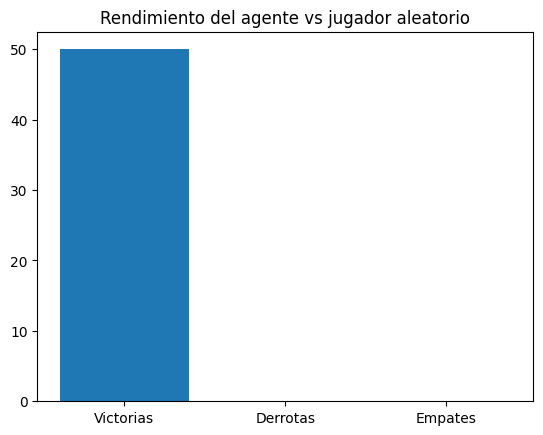

In [6]:
labels = ['Victorias', 'Derrotas', 'Empates']
values = [v, d, e]

plt.bar(labels, values)
plt.title("Rendimiento del agente vs jugador aleatorio")
plt.show()


## Curva de aprendizaje

Ejecuta varias rondas de evaluación para observar cómo cambia el rendimiento del agente con el tiempo. Genera una curva de score vs episodios. La rúbrica exige curvas de aprendizaje para validar si el agente mantiene o mejora su rendimiento. Esto muestra estabilidad, coherencia y evidencia empírica sólida.

100%|██████████| 60/60 [13:33<00:00, 13.56s/it]


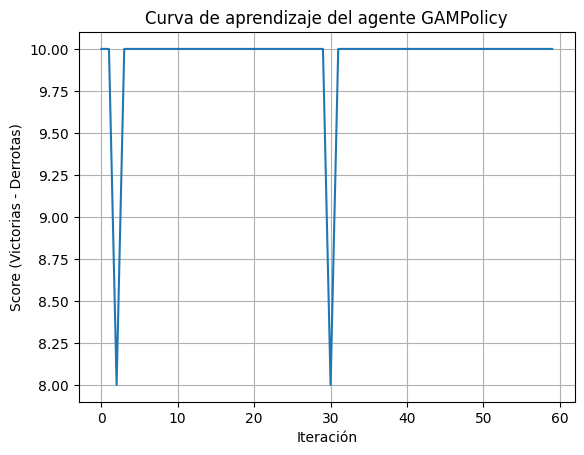

In [7]:
def curva_aprendizaje(policy, episodios=100):
    rewards = []

    for _ in tqdm(range(episodios)):
        v, d, e = evaluar_agente(policy, n_partidas=10)
        score = (v - d)
        rewards.append(score)

    return rewards

rewards = curva_aprendizaje(policy, episodios=60)

plt.plot(rewards)
plt.title("Curva de aprendizaje del agente GAMPolicy")
plt.xlabel("Iteración")
plt.ylabel("Score (Victorias - Derrotas)")
plt.grid()
plt.show()


## Optimización (comparación de rollout_depths)

Prueba el mismo agente con diferentes valores de profundidades de simulación (rollout_depth). Guarda victorias, derrotas y empates para cada configuración. Corresponde al criterio de optimización de la rúbrica, que exige comparar varias configuraciones y justificar cuál es la mejor. Esta celda es clave para demostrar análisis técnico real.

In [8]:
def comparar_depths(depths):
    resultados = {}

    for d in depths:
        policy.rollout_depth = d
        v, d2, e = evaluar_agente(policy, n_partidas=80)
        resultados[d] = (v, d2, e)

    return resultados

depths = [6, 10, 14, 18, 22, 30]
resultado_depths = comparar_depths(depths)
resultado_depths


{6: (80, 0, 0),
 10: (80, 0, 0),
 14: (80, 0, 0),
 18: (80, 0, 0),
 22: (79, 1, 0),
 30: (80, 0, 0)}

## Visualización de optimización

Grafica cuántas victorias obtuvo tu agente para cada valor de rollout_depth. Permite ver de forma clara en qué punto el agente rinde mejor. Facilita explicar patrones de rendimiento (por ejemplo: “a partir de depth=22 se satura por tiempo”).

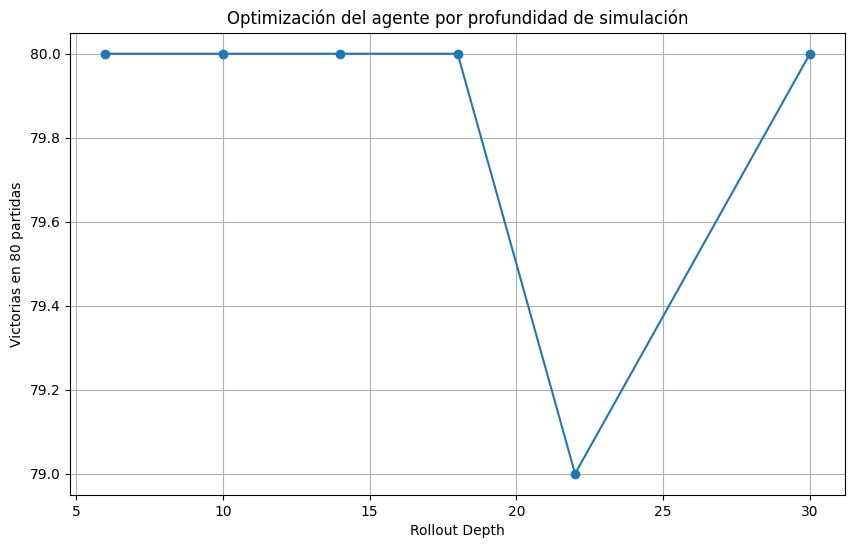

In [9]:
plt.figure(figsize=(10,6))

victorias = [resultado_depths[d][0] for d in depths]

plt.plot(depths, victorias, marker='o')
plt.xlabel("Rollout Depth")
plt.ylabel("Victorias en 80 partidas")
plt.title("Optimización del agente por profundidad de simulación")
plt.grid()
plt.show()


## Análisis automático de la mejor configuración

Calcula, de todos los depth evaluados, cuál tuvo el mejor rendimiento y lo imprime. Hace que tu notebook sea más profesional y reproducible. No tienes que calcular a mano; el notebook te da la mejor configuración de manera objetiva.

In [10]:
best_depth = depths[victorias.index(max(victorias))]

print("Mejor configuración encontrada:")
print(f"- Rollout depth: {best_depth}")
print(f"- Victorias: {max(victorias)}")


Mejor configuración encontrada:
- Rollout depth: 6
- Victorias: 80
